In [49]:
import pandas as pd
import numpy as np
import spacy

dataset_path = "DataSet/dataset_1.csv"
df = pd.read_csv(dataset_path)

In [50]:
df.describe()

,id,taxon.id,taxon.rank_level
count,1.084290e+05,1.084290e+05,108429.000000
mean,1.444728e+08,1.716065e+05,12.120881
std,7.169316e+07,1.982876e+05,4.398103
min,7.918000e+03,4.999500e+04,5.000000
25%,8.421476e+07,5.248900e+04,10.000000
50%,1.586697e+08,6.919000e+04,10.000000
75%,2.150840e+08,3.226920e+05,10.000000
max,2.533464e+08,1.495617e+06,30.000000


In [51]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique values: {unique_values[:20]}")  # Displaying only the first 10 unique values for brevity
    print(f"Total unique values: {len(unique_values)}\n")

Column: id
Unique values: [  7918   7922  23923 188235 294726 299015 322683 345187 346407 346434
 346448 346451 355503 363410 377184 377186 377187 377188 377189 391317]
Total unique values: 108429

Column: species_guess
Unique values: ['long hoverfly' 'sphaerophoria' 'volucella pellucens'
 'american thintail fly' 'dangling swamp-lover' 'sericomyia silentis'
 'marmalade hoverfly' 'meliscaeva auricollis' 'thick-legged hoverfly'
 'stripe-winged drone fly' 'eristalis intricaria' 'common hover flies'
 'leucozona glaucia' 'blaue breitbandschwebfliege' 'long hover fly'
 'tapered dronefly' 'syrphus' 'chrysogaster solstitialis'
 'leucozona laternaria' 'cheilosia illustrata']
Total unique values: 736

Column: time_observed_at
Unique values: [nan '2013-07-06T15:53:53+01:00' '2013-07-24T01:35:25+01:00'
 '2013-07-26T11:42:17+01:00' '2013-07-26T10:57:12+01:00'
 '2013-07-26T11:22:01+01:00' '2013-07-26T10:53:01+01:00'
 '2013-08-01T12:17:59+01:00' '2013-08-10T13:48:01+01:00'
 '2013-08-25T16:33:54+01:00

In [52]:
df["species_guess"].value_counts()

species_guess
marmalade hover fly    7799
tapered drone fly      7745
common drone fly       5722
sun fly                5108
common flower flies    4797
                       ... 
brachyopa pilosa          1
stor droneflue            1
短額巴蚜蠅                     1
kleine bijvlieg           1
alder halfband            1
Name: count, Length: 736, dtype: int64

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from fuzzywuzzy import process, fuzz
from joblib import Parallel, delayed

nlp = spacy.load("en_core_web_lg")

In [54]:
def normalize_text(text):
    return text.lower().strip()

# Function to compute text similarity matrix
def compute_similarity_matrix(texts):
    docs = nlp.pipe(texts)
    vectors = np.array([doc.vector for doc in docs])

    norms = np.linalg.norm(vectors, axis=1)
    zero_norm_indices = np.where(norms == 0)[0]

    if len(zero_norm_indices) > 0:
        vectors[zero_norm_indices] = (
            np.random.rand(len(zero_norm_indices), vectors.shape[1]) * 1e-6
        )

    norms = np.linalg.norm(vectors, axis=1)
    vectors = vectors / norms[:, np.newaxis]

    similarity_matrix = cosine_similarity(vectors)
    return similarity_matrix


# Function to compute fuzzy similarity matrix
def compute_fuzzy_similarity_matrix(texts):
    n = len(texts)
    similarity_matrix = np.zeros((n, n))

    def compute_similarity(i, j):
        if i != j:
            return fuzz.ratio(texts[i], texts[j]) / 100.0
        else:
            return 1.0

    results = Parallel(n_jobs=-1)(
        delayed(compute_similarity)(i, j) for i in range(n) for j in range(n)
    )
    similarity_matrix = np.array(results).reshape(n, n)
    return similarity_matrix

In [55]:
df["species_guess"] = df["species_guess"].apply(normalize_text)
texts = df["species_guess"][0:20]
print("texts: ", texts)

texts:  0                   long hoverfly
1                   sphaerophoria
2             volucella pellucens
3           american thintail fly
4            dangling swamp-lover
5            dangling swamp-lover
6             sericomyia silentis
7              marmalade hoverfly
8              marmalade hoverfly
9           meliscaeva auricollis
10          thick-legged hoverfly
11        stripe-winged drone fly
12            sericomyia silentis
13           eristalis intricaria
14            sericomyia silentis
15             marmalade hoverfly
16             common hover flies
17              leucozona glaucia
18    blaue breitbandschwebfliege
19                 long hover fly
Name: species_guess, dtype: object


In [56]:
similarity_matrix = compute_similarity_matrix(texts)
np.fill_diagonal(similarity_matrix, 1)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - pd.DataFrame(similarity_matrix)

# Clustering using dbscan
dbscan = DBSCAN(eps=0.15, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

[ 0  1  2  3  4  4  5  6  6  7  8  9 10 11 12  6 13 14 15 16]


[ 0  1  2  3  4  4  5  6  6  7  8  9  5 10  5  6 11 12 13  0]


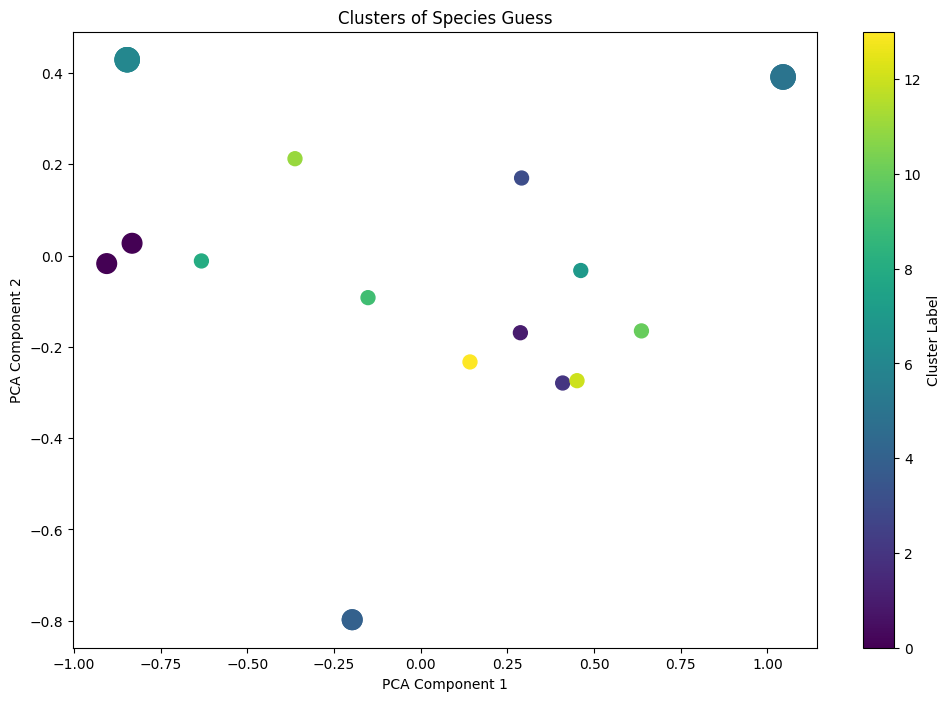

In [57]:
similarity_matrix = compute_fuzzy_similarity_matrix(texts)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix
dbscan = DBSCAN(eps=0.1, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

cluster_counts = np.bincount(clusters + 1)  # Add 1 to handle -1 (noise) cluster
sizes = cluster_counts[clusters + 1] * 100

# Plotting the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis", s=sizes
)
plt.title("Clusters of Species Guess")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")

plt.show()

In [ ]:
text_to_cluster = df["species_guess"]
similarity_matrix = compute_fuzzy_similarity_matrix(text_to_cluster)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix
dbscan = DBSCAN(eps=0.1, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)

5000
